# DiscreteDP Example: POMDP Tiger Example

We solve the Tiger Example,
a famous example of POMDP (Partially Observable Markov Decision Process),
by discretizing the belief state of the corresponding MDP.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

States (in POMDP):
* `s_L`: Tiger is on the left
* `s_R`: Tiger is on the right

Actions:
* 0: Listen
* 1: Open left
* 2: Open right

Obervations:
* TL
* TR

States (in MDP):
* $s \in [0, 1]$: belief of state `s_R`

In [3]:
def prob_TL(belief, noise_prob_L=0.15, noise_prob_R=0.15):
    return (1-noise_prob_L) * (1-belief) + noise_prob_R * belief

def prob_TR(belief, noise_prob_L=0.15, noise_prob_R=0.15):
    return noise_prob_L * (1-belief) + (1-noise_prob_R) * belief

def bayes_update_TL(belief, noise_prob_L=0.15, noise_prob_R=0.15):
    return noise_prob_R * belief / prob_TL(belief, noise_prob_L, noise_prob_R)

def bayes_update_TR(belief, noise_prob_L=0.15, noise_prob_R=0.15):
    return (1-noise_prob_R) * belief / prob_TR(belief, noise_prob_L, noise_prob_R)

In [4]:
def nearest_idx(grid, v):
    mid_points = (grid[:-1] + grid[1:]) / 2
    return np.searchsorted(mid_points, v)

In [5]:
def tiger_mdp(belief_grid, beta=0.95):
    # Number of actions
    num_actions = 3
    # Actions
    # 0: Listen, 1: OpenL, 2:OpenR

    # Number of state-action pairs
    grid_size = len(belief_grid)
    L = grid_size * num_actions

    s_indices = np.repeat(np.arange(grid_size), num_actions)
    a_indices = np.tile(np.arange(num_actions), grid_size)

    # Reward vector
    reward = 10
    penalty = -100
    cost = -1

    R = np.empty((grid_size, num_actions))
    # Listen
    R[:, 0] = cost
    # OpenL
    R[:, 1] = penalty * (1 - belief_grid) + reward * belief_grid
    # OpenR
    R[:, 2] = reward * (1 - belief_grid) + penalty * belief_grid

    R.shape = (L,)

    # Transition probability matrix
    data = np.empty(grid_size*(num_actions+1))
    row = np.empty(grid_size*(num_actions+1), dtype=int)
    col = np.empty(grid_size*(num_actions+1), dtype=int)

    # If listen:
    a = 0
    # observe TL with prob prob_TL
    data[a*grid_size:(a+1)*grid_size] = prob_TL(belief_grid)
    row[a*grid_size:(a+1)*grid_size] = np.arange(a, L, num_actions)
    col[a*grid_size:(a+1)*grid_size] = \
        nearest_idx(belief_grid, bayes_update_TL(belief_grid))
    # observe TL with prob prob_TR
    data[(a+1)*grid_size:(a+2)*grid_size] = prob_TR(belief_grid)
    row[(a+1)*grid_size:(a+2)*grid_size] = np.arange(a, L, num_actions)
    col[(a+1)*grid_size:(a+2)*grid_size] = \
        nearest_idx(belief_grid, bayes_update_TR(belief_grid))

    # Once open the door, the problem is reset
    prob_half_idx = np.abs(belief_grid-1/2).argmin()
    for a in [1, 2]:
        data[(a+1)*grid_size:(a+2)*grid_size] = 1
        row[(a+1)*grid_size:(a+2)*grid_size] = np.arange(a, L, num_actions)
        col[(a+1)*grid_size:(a+2)*grid_size] = prob_half_idx

    Q = sparse.coo_matrix((data, (row, col)), shape=(L,grid_size))
    Q.sum_duplicates()
    
    return DiscreteDP(R, Q, beta, s_indices, a_indices)

In [6]:
grid_size = 5001
belief_grid = np.linspace(0, 1, grid_size)

In [7]:
belief_grid

array([  0.00000000e+00,   2.00000000e-04,   4.00000000e-04, ...,
         9.99600000e-01,   9.99800000e-01,   1.00000000e+00])

In [8]:
mdp = tiger_mdp(belief_grid, beta=0.95)

In [9]:
res = mdp.solve(method='policy_iteration')

In [10]:
res.num_iter

3

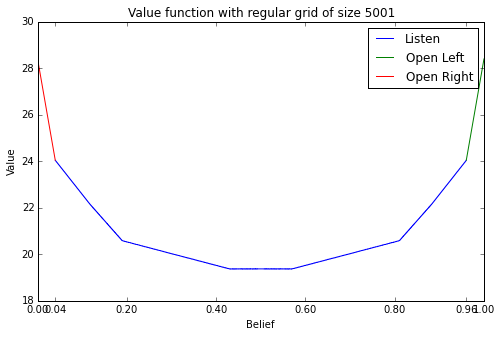

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
action_labels = ['Listen', 'Open Left', 'Open Right']
upper_bounds = np.empty(len(action_labels))
for a, label in enumerate(action_labels):
    segment = np.where(res.sigma==a)[0]
    ax.plot(belief_grid[segment], res.v[segment], label=label)
ax.set_title('Value function with regular grid of size {0}'.format(grid_size))
ax.set_xlabel('Belief')
ax.set_ylabel('Value')
cutoffs = (np.where(res.sigma==1)[0][0], np.where(res.sigma==2)[0][-1])
plt.xticks(list(plt.xticks()[0]) +
           [belief_grid[cutoff] for cutoff in cutoffs])
plt.legend()
plt.show()